In [1]:
% matplotlib inline
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import winsound
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import matplotlib.cm as cm

from scipy.special import expit
from scipy.optimize import minimize

from sklearn.metrics import accuracy_score

In [2]:
#load input data containing digits in mat format
digits = sio.loadmat('data/ex4data1.mat')

#save input and result of data
X = pd.DataFrame(digits['X'])
y = pd.get_dummies(pd.DataFrame(digits['y'])[0])
y.columns = list(range(0, 10))

#load computed weights
weights = sio.loadmat('data/ex4weights.mat')
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

In [3]:
def initialize_theta(params, eps=.12):
    """Randomly initialize the weights to small values
    Parameters
    ------------
    params : array
        List of arrays of theta to be initialized.
    eps : float
        Given weights will be initialized in range (-eps, eps),
        default: 0.12.
    Returns
    -----------
    init_theta : array,
        Array of len as given in params containing values in range (-eps, eps)
    """ 
    init_theta = []
    for theta in params:
        init_theta.append(np.random.random(theta.shape)*2*eps-eps)
    return init_theta

def reshapeParams(flattened_array, input_layer_size, hidden_layer_size, output_layer_size):
    """Reshapes flattened array and returns Theta **transposed** values 
        in respect of Neural network layer sizes. Given version is created 
        for layer with one hidden layer.
    Parameters
    ------------
    flattened_array : array
        Flattened array of Theta values.
    input_layer_size : array
        Size of input layer
    hidden_layer_size : array
        Size of hidden layer
    output_layer_size : array
        Size of output layer
    Returns
    -----------
    init_theta : array, len = 2
        Theta **transposed** values 
        in respect of Neural network layer sizes
    """ 
    theta1 = flattened_array[:(input_layer_size + 1) * hidden_layer_size] \
        .reshape((input_layer_size + 1, hidden_layer_size))
    theta2 = flattened_array[(input_layer_size + 1) * hidden_layer_size:] \
        .reshape((hidden_layer_size + 1, output_layer_size))
    return [theta1, theta2]

In [4]:
class NeuralNetwork(object):
    """ Implementation of Feedforward Neural Network with one hidden layer.
    """
    def __init__(self, lam, theta_params=None):
        self.lam = lam
        self.w1, self.w2 = self._initialize_weights(theta_params)
        self.cost = []

    def _sigmoid(self, z):
        return expit(z)

    def _sigmoid_gradient(self, z):
        sig = self._sigmoid(z)
        return sig * (1 - sig)

    def _add_bias_unit(self, df, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            x_new = np.ones((df.shape[0], df.shape[1] + 1))
            x_new[:, 1:] = df
        elif how == 'row':
            x_new = np.ones((df.shape[0] + 1, df.shape[1]))
            x_new[1:, :] = df
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return x_new

    def _feed_forward(self, X):
        a1 = self._add_bias_unit(X, how='column')
        z2 = a1.dot(self.w1)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='column')
        z3 = a2.dot(self.w2)
        a3 = self._sigmoid(z3)

        self.a = [a1, a2, a3]
        self.z = [z2, z3]
        return self.a, self.z

    def _calculate_cost(self, y, output, m):
        term1 = np.multiply(y.T, np.log(output))
        term2 = np.multiply((1 - y.T), np.log(1 - output))
        cost = term1 + term2
        reg_term = self._L2_reg(self.lam, self.w1, self.w2)
        reg_term = reg_term / m
        return -np.sum(np.sum(cost)) / m + reg_term

    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_ / 2.0) * (np.sum(w1[1:, :] ** 2) + np.sum(w2[1:, :] ** 2))

    def _backPropagate(self, y, m):
        a3 = self.a[-1]
        sigma3 = a3 - y

        z2 = self.z[0]
        sigma2 = sigma3.dot(self.w2[1:, :].T) * self._sigmoid_gradient(z2)

        a1 = self.a[0]
        a2 = self.a[1]

        grad1 = sigma2.T.dot(a1)
        grad2 = sigma3.T.dot(a2)

        theta_grad1 = grad1 / m
        theta_grad2 = grad2 / m
        theta_grad1 = np.array(theta_grad1)
        theta_grad2 = np.array(theta_grad2)

        grad1_reg = (self.lam / m) * self.w1[1:, :].T
        theta_grad1[:, 1:] += grad1_reg

        grad2_reg = (self.lam / m) * self.w2[1:, :].T
        theta_grad2[:, 1:] += grad2_reg

        return [theta_grad1, theta_grad2]

    def fit(self, X, y, epochs, display_progres=False):
        X_data, y_data = X.copy(), y.copy()
        m = X.shape[0]

        for i in range(1, epochs + 1):
            if display_progres & (i%10 == 0):
                print(f'Performing calculations for network: {i}/{epochs}')

            self._feed_forward(X_data)
            nn_output = pd.DataFrame(self.a[-1]).T
            self.gradients = nn._backPropagate(y, m)
            self.cost.append(self._calculate_cost(y_data, nn_output, m))
            self.w1 -= self.gradients[0].T
            self.w2 -= self.gradients[1].T
            
        self.nn_output = nn_output
        return self

    def _initialize_weights(self, theta_params):
        return theta_params[0].copy(), theta_params[1].copy()

input_layer_size = 2
hidden_layer_size = 2
output_layer_size = 4
params = np.array(list(range(1, 19))) / 10  # nn_params
theta_params = reshapeParams(params, input_layer_size, hidden_layer_size, output_layer_size)

X_t = pd.DataFrame(np.cos([[1, 2], [3, 4], [5, 6]]))
y_t = np.array([4, 2, 3])
y_t = pd.get_dummies(y_t)
zeros = np.zeros(y_t.shape[0])
y_t.insert(0, value=zeros, column='1')

lam = 0

nn = NeuralNetwork(lam, theta_params)
network_fitted = nn.fit(X_t, y_t, 1)
gradients = network_fitted.gradients
nn_output = network_fitted.nn_output
cost = network_fitted.cost
net_a = network_fitted.a
net_z = network_fitted.z

GRADIENTS_0_EXPECTED_NO_REG = np.array([[0.766138, -0.02754, -0.024929],
                                        [0.979897, -0.035844, -0.053862]])
EXPECTED_COST_NO_REG = 7.4070
TOL = 6
ARR_TOL = 1.e-6
COST_TOL = 1.e-3

gr = gradients[0]
gr = np.round(gr, TOL)
print('Gradients without regularization, calculated:\n', gr)
print('Expected:\n', GRADIENTS_0_EXPECTED_NO_REG)
no_reg_gradients_close_cond = np.isclose(gr, GRADIENTS_0_EXPECTED_NO_REG, atol=ARR_TOL)
print(f'No regularization gradients are the same:\n{no_reg_gradients_close_cond}')

cost_close = np.isclose(cost, EXPECTED_COST_NO_REG, atol=COST_TOL)
print(f'Cost is equal to expected with toleration {COST_TOL}: {cost_close}\n'
      f'Cost is equal to: {cost}, expected is: {EXPECTED_COST_NO_REG}')


GRADIENTS_0_EXPECTED_WITH_REG = np.array([[ 0.76614,  0.37246,  0.64174],
                                        [ 0.9799 ,  0.49749,  0.74614]])
EXPECTED_COST_WITH_REG = 19.474
lam = 4

nn = NeuralNetwork(lam, theta_params)
network_fitted = nn.fit(X_t, y_t, 1)
gradients = network_fitted.gradients
cost = network_fitted.cost
gr = gradients[0]
gr = np.round(gr, TOL)

print()
print('Gradients without regularization, calculated:\n', gr)
print('Expected:\n', GRADIENTS_0_EXPECTED_WITH_REG)
no_reg_gradients_close_cond = np.isclose(gr, GRADIENTS_0_EXPECTED_WITH_REG, atol=ARR_TOL)
print(f'Check if gradients without regularization are the same:\n{no_reg_gradients_close_cond}')

cost_close = np.isclose(cost, EXPECTED_COST_NO_REG, atol=COST_TOL)
print(f'Cost is equal to expected with toleration {COST_TOL}: {cost_close}\n'
      f'Cost is equal to: {cost}, expected is: {EXPECTED_COST_WITH_REG}')

Gradients without regularization, calculated:
 [[ 0.766138 -0.02754  -0.024929]
 [ 0.979897 -0.035844 -0.053862]]
Expected:
 [[ 0.766138 -0.02754  -0.024929]
 [ 0.979897 -0.035844 -0.053862]]
No regularization gradients are the same:
[[ True  True  True]
 [ True  True  True]]
Cost is equal to expected with toleration 0.001: [ True]
Cost is equal to: [7.40696985606575], expected is: 7.407

Gradients without regularization, calculated:
 [[ 0.766138  0.37246   0.641738]
 [ 0.979897  0.497489  0.746138]]
Expected:
 [[ 0.76614  0.37246  0.64174]
 [ 0.9799   0.49749  0.74614]]
Check if gradients without regularization are the same:
[[ True  True  True]
 [ True  True  True]]
Cost is equal to expected with toleration 0.001: [False]
Cost is equal to: [19.47363652273242], expected is: 19.474


In [5]:
COST_FUNC_WITH_REG = 0.383770
COST_FUNC_WITHOUT_REG = 0.287629
theta_params = [Theta1.T, Theta2.T]

lam = 0
nn = NeuralNetwork(lam, theta_params)
ff = nn.fit(X, y, 1)
print(f'Cost function should equal {COST_FUNC_WITHOUT_REG} without regularization, computed cost is: {ff.cost}')
np.testing.assert_almost_equal(ff.cost, COST_FUNC_WITHOUT_REG, decimal=6, err_msg='Gradient checking failed.')

lam = 1
nn = NeuralNetwork(lam, theta_params)
ff = nn.fit(X, y, 1)
print(f'Cost function should equal {COST_FUNC_WITH_REG} with regularization, computed cost is: {ff.cost}')
np.testing.assert_almost_equal(ff.cost, COST_FUNC_WITH_REG, decimal=6, err_msg='Gradient checking failed.')

Cost function should equal 0.287629 without regularization, computed cost is: [0.28762916516131881]
Cost function should equal 0.38377 with regularization, computed cost is: [0.38376985909092354]


In [6]:
%%time
lam = 0

theta_params = [Theta1.T, Theta2.T]
m = X.shape[0]

nn = NeuralNetwork(lam, theta_params)
network_fitted = nn.fit(X, y, 1)

gradients = network_fitted.gradients
nn_output = network_fitted.nn_output
nn_output.head(2)

y_true = pd.get_dummies(pd.DataFrame(digits['y'])) - 1
y_pred = nn_output.idxmax(axis=0).values
print('acc:', accuracy_score(y_true, y_pred))

winsound.PlaySound('sound.wav', winsound.SND_FILENAME)

acc: 0.9752
Wall time: 2.59 s


acc: 0.9394
Wall time: 24.8 s


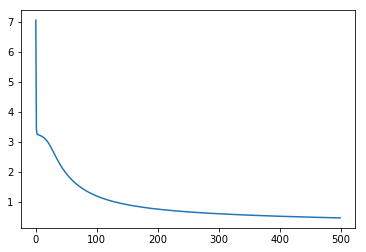

In [7]:
%%time
lam = 0

theta_params = [Theta1.T, Theta2.T]
init_theta = initialize_theta(theta_params)
m = X.shape[0]

nn = NeuralNetwork(lam, init_theta)
network_fitted = nn.fit(X, y, 500)

gradients = network_fitted.gradients
nn_output = network_fitted.nn_output
nn_cost = network_fitted.cost
nn_output.head(2)

y_true = pd.get_dummies(pd.DataFrame(digits['y'])) - 1
y_pred = nn_output.idxmax(axis=0).values
print('acc:', accuracy_score(y_true, y_pred))
plt.plot(range(0, len(nn_cost)), nn_cost)
winsound.PlaySound('sound.wav', winsound.SND_FILENAME)

acc: 0.9348
Wall time: 24.3 s


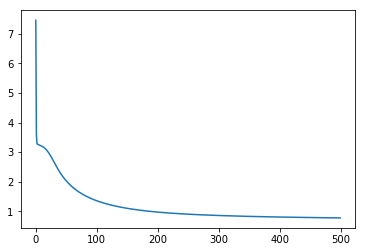

In [10]:
%%time
lam = 4

theta_params = [Theta1.T, Theta2.T]
init_theta = initialize_theta(theta_params)
m = X.shape[0]

nn = NeuralNetwork(lam, init_theta)
network_fitted = nn.fit(X, y, 500)

gradients = network_fitted.gradients
nn_output = network_fitted.nn_output
nn_cost = network_fitted.cost
nn_output.head(2)

y_true = pd.get_dummies(pd.DataFrame(digits['y'])) - 1
y_pred = nn_output.idxmax(axis=0).values
print('acc:', accuracy_score(y_true, y_pred))
plt.plot(range(0, len(nn_cost)), nn_cost)
winsound.PlaySound('sound.wav', winsound.SND_FILENAME)

In [9]:
import random

def calculate_cost(X, y, size, lam, params):
    return NeuralNetwork(lam, params).fit(X, y, 1).cost

def get_random_index_of_ndarray(array):
    return random.randint(0, array.shape[0]-1), \
           random.randint(0, array.shape[1] - 1)

def perform_gradient_checking(X, y, backpropag, theta_params):
    eps = .0001
    lam = 0
    data_frames = []
    m = X.shape[0]
    t1 = theta_params[0]

    for i in range(1, 11):
        rand_index = get_random_index_of_ndarray(t1)
        t1[rand_index] = t1[rand_index] + eps
        left = calculate_cost(X, y, m, lam, theta_params)[0]
        t1[rand_index] = t1[rand_index] - 2*eps
        right = calculate_cost(X, y, m, lam, theta_params)[0]
        num_res = (left - right)/(2*eps)
        backprop_res = backpropag[0].T[rand_index]
        norm = np.linalg.norm(num_res - backprop_res) / np.linalg.norm(num_res + backprop_res)
        norm1 = np.linalg.norm(num_res - backprop_res)
        norm2 = np.linalg.norm(num_res + backprop_res)
        norm_diff = norm1/norm2
        
        norm2 = np.linalg.norm(num_res)
        norm3 = np.linalg.norm(backprop_res)
        relative_error = norm1 / (norm2 + norm3)
        data_frames.append(pd.DataFrame([str(rand_index), num_res, backprop_res,
                                         norm_diff, relative_error, np.linalg.norm(num_res- backprop_res)]).T)

    df = pd.concat(data_frames)
    df.columns = ['Index', 'num_res', 'backprop_res', 'norm_diff(num-grad)', 'relative_error', 'num-backprop']
    return df

theta_params = [Theta1.T, Theta2.T]
lam = 0
nn = NeuralNetwork(lam, theta_params)

network_fitted = nn.fit(X, y, 1)
gradients = network_fitted.gradients
nn_output = network_fitted.nn_output

gradient_df = perform_gradient_checking(X, y, gradients, theta_params)
gradient_df
gradient_df.iloc[:,-3].mean()
gradient_df.iloc[:,-2].mean()
gradient_df.iloc[:,-1].mean()

,Index,num_res,backprop_res,norm_diff(num-grad),relative_error,num-backprop
0,"(225, 13)",-0.00011151,-0.00011151,2.77436e-09,2.77436e-09,6.1874e-13
0,"(155, 1)",8.87448e-05,8.87812e-05,0.000205103,0.000205103,3.6411e-08
0,"(95, 14)",0.00023778,0.000237771,1.96435e-05,1.96435e-05,9.34148e-09
0,"(57, 20)",-2.02853e-06,-2.02846e-06,1.55354e-05,1.55354e-05,6.3027e-11
0,"(36, 10)",7.09273e-07,7.09429e-07,0.000109923,0.000109923,1.55948e-10
0,"(183, 8)",-3.32833e-05,-3.32844e-05,1.6089e-05,1.6089e-05,1.07101e-09
0,"(90, 14)",2.0094e-05,2.0101e-05,0.00017383,0.00017383,6.98712e-09
0,"(342, 24)",-1.96979e-07,-1.9699e-07,2.80558e-05,2.80558e-05,1.10531e-11
0,"(109, 9)",-0.000153753,-0.000153738,4.76664e-05,4.76664e-05,1.4657e-08
0,"(30, 11)",-2.45311e-06,-2.45315e-06,6.77247e-06,6.77247e-06,3.32275e-11


6.2262126392626516e-05

6.2262126392626516e-05

6.8731505885008939e-09